In [1]:
if True:
    _ = !pip install -r /kaggle/working/PIKAN/requirements.txt
    
if True:
    !git clone https://github.com/DavidCanoRosillo/PIKAN.git

fatal: destination path 'PIKAN' already exists and is not an empty directory.


In [1]:
import sys
# kaggle execution things
sys.path.append('/kaggle/working/PIKAN')

In [2]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import numpy as np
from pikan.model_utils import GeneralizedMLP, sobol_sample
from jax import grad, vmap, jit
from jax.scipy.special import gamma
from functools import partial
import optax

import os
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

jax.devices()

[CudaDevice(id=0)]

In [3]:
model = GeneralizedMLP(
    kernel_init=nn.initializers.glorot_normal(),
    num_input=2,
    num_output=1,
    use_fourier_feats=True,
    layer_sizes=[256, 256, 256, 256],
)

key = jax.random.PRNGKey(0)
collocs = jnp.ones((2))
params = model.init(key, collocs)['params']
model.apply({"params": params}, collocs)

Array([1.10994], dtype=float32)

In [4]:
# Define the inference function
def inference(params, model, x, t):
    x = jnp.stack([x,t])
    return model.apply({'params': params}, x)

inference(params, model, 0, 1)

Array([0.46476573], dtype=float32)

In [5]:
def inference(params, x, t):
    output = model.apply({'params': params}, jnp.array([x, t]))
    return output[0]

def get_caputo_derivative(inference, alpha):
    @jax.jit
    def caputo_derivative(params, x, t, dt=1e-3, num_steps = 500):
        """
        Compute the Caputo derivative of order alpha for a function f(x, t) with respect to t.
    
        Parameters:
        - f: A function f(x, t) that takes two arguments, x and t.
        - x: The spatial variable.
        - t: The time variable.
        - alpha: The order of the Caputo derivative (0 < alpha < 1).
        - dt: The time step for discretization.
    
        Returns:
        - The Caputo derivative of f(x, t) at time t.
        """
        # Define the integrand
        def integrand(tau):
            return grad(inference, 2)(params, x, tau) / (t - tau)**alpha
    
        # Fixed number of steps for static shape
        tau_values = jnp.linspace(0, t - dt, num_steps)  # Exclude t
        integrand_values = vmap(integrand)(tau_values)
    
        # Compute the integral using the trapezoidal rule
        integral = jnp.trapezoid(integrand_values, tau_values)
    
        # Normalize by the gamma function
        return integral / gamma(1 - alpha)
    
    return caputo_derivative
    
x = 1.0
t = 1.0
alpha = 0.5

caputo_derivative_fn = get_caputo_derivative(inference, alpha)
caputo_deriv = caputo_derivative_fn(params, x, t)

print("Caputo Derivative:", caputo_deriv)

Caputo Derivative: 1.1158679


In [6]:
import jax.numpy as jnp
from jax import grad, vmap
from scipy.special import gamma

def compute_caputo_derivative(params, x_mesh, t_mesh, t_lins, alpha, inference):
    """
    Compute the Caputo derivative at each point in the mesh.

    Args:
        x_lins (jnp.ndarray): Spatial mesh points (1D array).
        t_lins (jnp.ndarray): Temporal mesh points (1D array).
        alpha (float): Fractional order of the derivative.
        inference (callable): Function to compute the integrand, of the form inference(params, x, tau).
        params: Optional parameters for the inference function.

    Returns:
        jnp.ndarray: Caputo derivative at each point in the mesh, with shape (len(x_lins), len(t_lins)).
    """
    # Create a meshgrid
    # x_mesh, t_mesh = jnp.meshgrid(x_lins, t_lins, indexing="ij")
    
    # Define the integrand function
    def integrand(x, tau):
        return grad(inference, 2)(params, x, tau)  # Gradient w.r.t. tau

    # Vectorize the integrand over the mesh
    integrand_vals = vmap(vmap(integrand, (0, 0)), (0, 0))(x_mesh, t_mesh)

    # Compute dt for non-uniform meshes
    dt = jnp.diff(t_lins, append=0.0)  # Append 0.0 to match the shape of t_lins

    # Define the mask function
    def mask_t(t, t_mesh):
        return 1 / (t - t_mesh) ** alpha

    # Apply the mask and sum with dt weights
    def apply_mask(spatial_row, time_mask):
        return jnp.sum(spatial_row * time_mask * dt, axis=1)  # Weight by dt

    # Compute the result
    res = vmap(mask_t, (0, None))(t_lins, t_lins)
    res = jnp.nan_to_num(res, posinf=0.0, neginf=0.0)  # Handle singularities

    res = vmap(apply_mask, (None, 0))(integrand_vals, res)
    res = jnp.moveaxis(res, (0, 1), (1, 0)) / gamma(1 - alpha)

    return res

In [7]:
x_lins = jnp.linspace(-1, 1, 500)
t_lins = jnp.linspace(0, 1, 300)
alpha = 0.5
x_mesh, t_mesh = jnp.meshgrid(x_lins, t_lins, indexing="ij")

caputo_derivative = compute_caputo_derivative(params, x_mesh, t_mesh, t_lins, alpha, inference)

print(caputo_derivative[:, 10:].shape)

(500, 290)


In [8]:
# caputo diffusion on 1d
class fractional_diffusion():
    def __init__(self, model, bc_l, bc_r, ic_func, alpha, t_lins, dom=[-1,1]):
        self.bc_l = bc_l # boundary vals
        self.bc_r = bc_r

        self.ic_collocs = jnp.linspace(dom[0], dom[1], 1000)
        self.ic_vals = ic_func(self.ic_collocs) # t_0 values
        
        self.alpha = alpha
        self.dom = dom

        # paralellize for faster computation
        self.neural_net_fn = jax.vmap(self.neural_net, (None, 0, 0))
        
        self.t_lins = t_lins
        self.D = 1
        
    def neural_net(self, params, x, t):
        output = model.apply({'params': params}, jnp.array([x, t]))
        return output[0]
    
    def residual_mesh_loss(self, params, x_mesh, t_mesh):
        laplacian_fn = jax.vmap(jax.vmap(
            grad(grad(inference, argnums=1), argnums=1), (None, 0,0)
        ), (None, 0,0))
        
        caputo_derivative = compute_caputo_derivative(params, x_mesh, t_mesh, 
                            self.t_lins, self.alpha, self.neural_net)
        
        laplacian = laplacian_fn(params, x_mesh, t_mesh)
        
        return caputo_derivative - self.D*laplacian
    
    def mse(self, arr):
        return jnp.mean(arr**2)
    
    @partial(jit, static_argnums=(0,))
    def loss(self, params, collocs, x_mesh, t_mesh):
        ic_preds = self.neural_net_fn(params, self.ic_collocs, jnp.zeros_like(self.ic_collocs))
        
        bc_l_preds = self.neural_net_fn(params, jnp.full_like(collocs[:,1], self.dom[0]), collocs[:,1])
        bc_r_preds = self.neural_net_fn(params, jnp.full_like(collocs[:,1], self.dom[1]), collocs[:,1])

        eq_loss = self.residual_mesh_loss(params, x_mesh, t_mesh)[:, 10:]

        # losses could be added with custom weights, TODO gradnorm
        loss = self.mse(ic_preds - self.ic_vals) + self.mse(bc_l_preds - self.bc_l) + \
               self.mse(bc_r_preds - self.bc_r) + 1e-3*self.mse(eq_loss)

        new_loc_w = 0 # maybe implement local weights
        return loss, new_loc_w 

def ic_func(x, sigma=0.3):
    return jnp.exp(-x**2 / (2 * sigma**2)) * (1 - x**2)

In [9]:
def generate_temporal_mesh(T, num_points, grading_exponent=3.0):
    """
    Generate a temporal mesh with points clustered near t=0.
    
    Args:
        T (float): Total time (max value in the mesh).
        num_points (int): Number of temporal points.
        grading_exponent (float): Controls point density near t=0 (higher = denser).
    
    Returns:
        jnp.ndarray: Temporal mesh including t=0 (shape: (num_points,)).
    """
    i = jnp.linspace(0, 1, num_points)
    return T * (i ** grading_exponent)

In [10]:
# ic_func=lambda x: jnp.cos(x*jnp.pi/2)

x_lins = jnp.linspace(-1, 1, 150)
t_lins = generate_temporal_mesh(1, 300, grading_exponent=2)
x_mesh, t_mesh = jnp.meshgrid(x_lins, t_lins, indexing="ij")

fdiff = fractional_diffusion(model, 0, 0, ic_func=ic_func, alpha=.5, t_lins=t_lins)
fdiff.neural_net(params, 0., 1.)

fdiff.mse(fdiff.residual_mesh_loss(params, x_mesh, t_mesh))

Array(1306.462, dtype=float32)

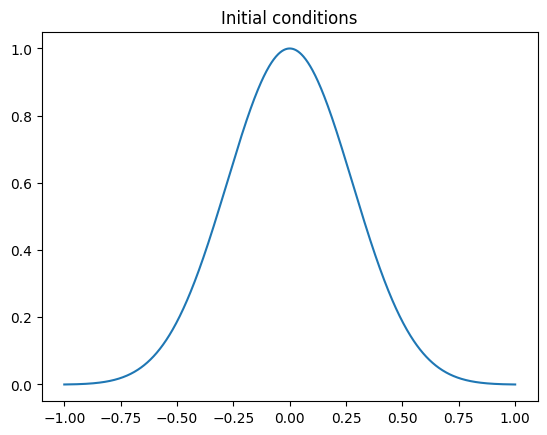

In [11]:
plt.plot(fdiff.ic_collocs, fdiff.ic_vals)
plt.title('Initial conditions')
_ = plt.plot()

In [12]:
# Define your gradient function
grad_fn = jax.value_and_grad(fdiff.loss, has_aux=True)

# Define the training loop
def train_step(params, collocs, x_mesh, t_mesh, opt_state):
    # Compute loss and gradients
    (loss, new_loc_w), grads = grad_fn(params, collocs, x_mesh, t_mesh)

    # Apply gradients to update the parameters
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    return params, opt_state, loss

In [13]:
EPOCHS = 1000

# Define a cosine decay learning rate schedule
# Learning rate schedule (cosine decay)
schedule_fn = optax.cosine_decay_schedule(
    init_value=1e-3,      # Initial learning rate
    decay_steps=2000,     # Total number of decay steps
    alpha=0.1             # Final learning rate multiplier
)

# Optimizer setup with Adam
optimizer = optax.adamw(
    learning_rate=schedule_fn,
    b1=0.9,               # Beta1
    b2=0.999,             # Beta2
    eps=1e-8              # Epsilon
)

opt_state = optimizer.init(params)

In [14]:
# Function to save parameters and state
def save_checkpoint(params, opt_state, epoch, filename):
    with open(filename, "wb") as f:
        pickle.dump({'params': params, 'opt_state': opt_state, 'epoch': epoch}, f)
    print(f"Checkpoint saved at epoch {epoch}")

def load_checkpoint(filename, params, state):
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            checkpoint = pickle.load(f)
        print(f"Checkpoint loaded from epoch {checkpoint['epoch']}")
        return checkpoint['params'], checkpoint['opt_state'], checkpoint['epoch']
    return params, state, 0 

In [15]:
# Define constants
BS = 2048
EPOCHS = 2000
TMAX = 1

CHECKPOINT_FILE = "new_123.pkl"
params, opt_state, start_epoch = load_checkpoint(CHECKPOINT_FILE, params, opt_state)

# mesh of spatio-temporal coordinates
x_mesh, t_mesh = jnp.meshgrid(x_lins, t_lins, indexing="ij")

# Main training loop
for i in (pbar := tqdm(range(start_epoch, EPOCHS))):
    collocs = sobol_sample(np.array([-1, 0]), np.array([1, TMAX]), BS)
    
    params, opt_state, loss = train_step(params, collocs, x_mesh, t_mesh, opt_state)
    
    if i % 50 == 0:
        pbar.set_description(f"Loss {loss: .8f}")
    
    if i % 250 == 0:  # Save every x epochs
        save_checkpoint(params, opt_state, i, CHECKPOINT_FILE)

save_checkpoint(params, opt_state, i, CHECKPOINT_FILE)

Loss  3.05942440:   0%|          | 2/2000 [00:05<1:10:03,  2.10s/it]

Checkpoint saved at epoch 0


Loss  0.00281875:  13%|█▎        | 252/2000 [00:30<03:04,  9.49it/s]

Checkpoint saved at epoch 250


Loss  0.00215285:  25%|██▌       | 502/2000 [00:56<02:36,  9.57it/s]

Checkpoint saved at epoch 500


Loss  0.00181436:  38%|███▊      | 752/2000 [01:21<02:10,  9.58it/s]

Checkpoint saved at epoch 750


Loss  0.00159606:  50%|█████     | 1002/2000 [01:47<01:46,  9.40it/s]

Checkpoint saved at epoch 1000


Loss  0.00144817:  63%|██████▎   | 1252/2000 [02:13<01:19,  9.39it/s]

Checkpoint saved at epoch 1250


Loss  0.00135100:  75%|███████▌  | 1502/2000 [02:39<01:04,  7.77it/s]

Checkpoint saved at epoch 1500


Loss  0.00129028:  88%|████████▊ | 1752/2000 [03:05<00:26,  9.36it/s]

Checkpoint saved at epoch 1750


Loss  0.00125665: 100%|██████████| 2000/2000 [03:31<00:00,  9.44it/s]

Checkpoint saved at epoch 1999


In [19]:
#CHECKPOINT_FILE = "buffer_v8.pkl"

# Initialize or load checkpoint
params, opt_state, start_epoch = load_checkpoint(CHECKPOINT_FILE, params, opt_state)

Checkpoint loaded from epoch 1999


In [24]:
x_space = jnp.linspace(-1, 1, 100)
t_space = jnp.linspace(0, 1, 300)

x_mesh, t_mesh = jnp.meshgrid(x_space, t_space, indexing='ij')
x_flat = x_mesh.reshape(-1)
t_flat = t_mesh.reshape(-1) 

u_flat = fdiff.neural_net_fn(params, x_flat, t_flat)
u_xt = u_flat.reshape(x_mesh.shape) 

In [25]:
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib.animation import PillowWriter
from IPython.display import HTML

# Initialize the figure
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(x_space.min(), x_space.max())
ax.set_ylim(u_xt.min(), u_xt.max())
ax.set_xlabel('x')
ax.set_ylabel('u(x, t)')
ax.set_title('Animation of u(x, t)')

# Animation update function
def update(frame):
    line.set_data(x_space, u_xt[:, frame])  # Set x and corresponding u values
    ax.set_title(r'Animation of $u(x, t)$ at $\Delta t = {:.2f}$'.format(t_space[frame]))
    return line,

# Create animation
ani = anim.FuncAnimation(
    fig, update, frames=len(t_space), blit=True, interval=100
)

plt.close(fig)
ani.save('CaputoDiffusion.gif', writer=PillowWriter(fps=15))

HTML(ani.to_jshtml())